<a href="https://colab.research.google.com/github/hemanth346/eva4/blob/master/S5/M1_S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model 1

### Target :

1. Get the setup right
    1. See/know the data 
> (skipping for mnist)
        1. Set basic transformation(to_tensor)
        1. Decide RF for edges/gradients
        1. Get Mean and standard deviation values of the dataset
        1. Decide transforms to use
    1. Set Transformations compose
    1. Set Data Loader
    1. Set Basic working code
    1. Set Basic Training and Test loop

1. Set the architecture
    1. Transformational block after RF of 5
    1. Get Conv layer before GAP to not less than 5px to retain info
    1. Use a FC/pointwise after GAP (allows usage of more features for prediction)
    1. Use less than 9.5k Param, Fully-Conv network
    1. Achieve round 99% train and test acc
    1. No BN, No dropout

### Results :
    
1. Parameters: 8,570
1. Best Train Accuracy: 98.72
1. Best Test Accuracy: 98.97 

### Analysis
1. Model is under-fitting slightly. 
1. Could be due to below reasons
    - Since model is not complex enough it may not able to genaralize properly
    - Model architecture is the culprit, could be due to maxpool is used early on due to param  restriction and o/p size 


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from IPython.display import Image # to display PIL images


In [0]:
# # dataset - Creating train and test
# train = datasets.MNIST('./data', train=True, download=True)
# test = datasets.MNIST('./data', train=False, download=True)
# # As PIL.Image
# x, y = train[7777]
# print(y)
# display(x)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
# dataset - Creating train and test
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


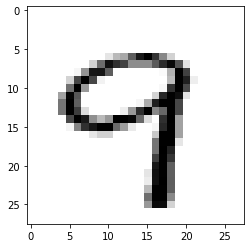

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


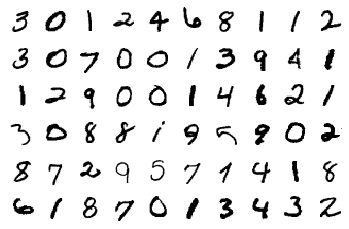

In [0]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [0]:
def conv_block(in_channels, out_channels, dropout=0, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, *args, **kwargs),
        nn.ReLU(),
        )
    


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = conv_block(in_channels=1, out_channels=10, kernel_size=3, padding=1, bias=False)
        self.conv2 = conv_block(in_channels=10, out_channels=16, kernel_size=3, bias=False)
        self.pool = nn.MaxPool2d(2, 2)                                                                                    
        
        self.conv3 = conv_block(in_channels=16, out_channels=10, kernel_size=3, padding=1, bias=False) 
        self.conv4 = conv_block(in_channels=10, out_channels=20, kernel_size=3, bias=False)          
        # self.pool = nn.MaxPool2d(2, 2)                                                                                 
        self.conv5 = conv_block(in_channels=20, out_channels=10, kernel_size=3, padding=1, bias=False)           

        # No relu before GAP/Last layer
        self.conv6 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1, bias=False)                        
        self.gap = nn.AdaptiveAvgPool2d((1,1))                                                                              
        self.pconv1 = nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1, bias=False, padding=0)         

    def forward(self, x):
        x = self.pool(self.conv2(self.conv1(x)))
        x = self.pool(self.conv4(self.conv3(x)))
        x = self.conv6(self.conv5(x))
        x = self.gap(x)
        x = self.pconv1(x)
        x = x.view(-1, 10)

        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 16, 26, 26]           1,440
              ReLU-4           [-1, 16, 26, 26]               0
         MaxPool2d-5           [-1, 16, 13, 13]               0
            Conv2d-6           [-1, 10, 13, 13]           1,440
              ReLU-7           [-1, 10, 13, 13]               0
            Conv2d-8           [-1, 20, 11, 11]           1,800
              ReLU-9           [-1, 20, 11, 11]               0
        MaxPool2d-10             [-1, 20, 5, 5]               0
           Conv2d-11             [-1, 10, 5, 5]           1,800
             ReLU-12             [-1, 10, 5, 5]               0
           Conv2d-13             [-1, 20, 5, 5]           1,800
AdaptiveAvgPool2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.2956347465515137 Batch_id=468 Accuracy=10.94: 100%|██████████| 469/469 [00:09<00:00, 49.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2964, Accuracy: 1010/10000 (10.10%)

EPOCH: 1


Loss=0.17319011688232422 Batch_id=468 Accuracy=57.58: 100%|██████████| 469/469 [00:09<00:00, 49.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2279, Accuracy: 9326/10000 (93.26%)

EPOCH: 2


Loss=0.16449277102947235 Batch_id=468 Accuracy=93.86: 100%|██████████| 469/469 [00:09<00:00, 47.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1140, Accuracy: 9646/10000 (96.46%)

EPOCH: 3


Loss=0.24977433681488037 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:10<00:00, 46.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0849, Accuracy: 9732/10000 (97.32%)

EPOCH: 4


Loss=0.07076645642518997 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:09<00:00, 47.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0703, Accuracy: 9779/10000 (97.79%)

EPOCH: 5


Loss=0.07214853167533875 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:09<00:00, 48.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9806/10000 (98.06%)

EPOCH: 6


Loss=0.0518978089094162 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:09<00:00, 48.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9819/10000 (98.19%)

EPOCH: 7


Loss=0.10694322735071182 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:09<00:00, 49.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9709/10000 (97.09%)

EPOCH: 8


Loss=0.023558909073472023 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:09<00:00, 49.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9843/10000 (98.43%)

EPOCH: 9


Loss=0.03737862408161163 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:09<00:00, 47.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9813/10000 (98.13%)

EPOCH: 10


Loss=0.08830852061510086 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:09<00:00, 47.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0558, Accuracy: 9820/10000 (98.20%)

EPOCH: 11


Loss=0.019830187782645226 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:09<00:00, 48.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9860/10000 (98.60%)

EPOCH: 12


Loss=0.07367154210805893 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:09<00:00, 49.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9870/10000 (98.70%)

EPOCH: 13


Loss=0.027227619662880898 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:09<00:00, 48.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9873/10000 (98.73%)

EPOCH: 14


Loss=0.0034978787880390882 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:10<00:00, 46.79it/s]



Test set: Average loss: 0.0342, Accuracy: 9897/10000 (98.97%)



Text(0.5, 1.0, 'Test Accuracy')

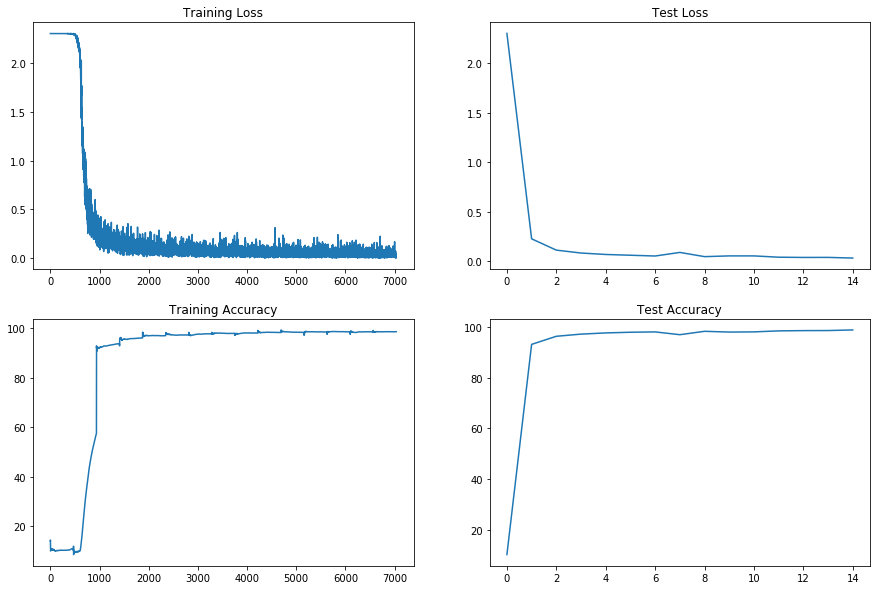

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")